# Amazon SageMaker Ground Truth for Human Annotations
To incorporate human feedback into your human review workflows, you need the following resources:

- *Workforce* to label your dataset. You can choose either the Amazon Mechanical Turk workforce, a vendor-managed workforce, or you can create your own private workforce for human reviews. Whichever workforce type you choose, Amazon Ground Truth takes care of sending tasks to workers.

- *Worker Task Template* to create a Human Task UI for the worker. The worker UI displays your input data, such as documents or images, and instructions to workers. It also provides interactive tools that the worker uses to complete your tasks. For more information, see https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-instructions-overview.html

- *Flow Definition* to create a Human Review Workflow. You use the flow definition to configure your human workforce and provide information about how to accomplish the human review task. You can create a flow definition in the SageMaker Ground Truth console or with APIs. To learn more about both of these options, see https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html

- *Human Loop* starts your human review workflow. When you use one of the built-in task types, the corresponding AWS service creates and starts a human loop on your behalf when the conditions specified in your flow definition are met or for each object if no conditions were specified. When a human loop is triggered, human review tasks are sent to the workers as specified in the flow definition.

When using a custom task type, as this notebook will show, you start a human loop using the AWS API. When you call StartHumanLoop in your custom application, a task is sent to human reviewers.

# Table of Contents

The notebook will be structured as follows:

- [ 1 - Set up Kernel and Required Dependencies](#1---set-up-kernel-and-required-dependencies)
- [ 2 - Load Sagemaker Dependencies and setup SageMaker Session](#2---load-sagemaker-dependencies-and-setup-sagemaker-session)
    - [ 2.1 - Setup the Workforce and Workteam](#21---setup-the-workforce-and-workteam)
    - [ 2.2 - Create the Human Task UI using a Worker Task Template](#22---create-the-human-task-ui-using-a-worker-task-template)
- [ 3 - Create a Flow Definition](#3---create-a-flow-definition)
    - [ 3.1 - Describe flow definition](#31---describe-flow-definition)
    - [ 3.2 - Add items for human feedback](#32---add-items-for-human-feedback)
    - [ 3.3 - Check Status of Human Loop](#33---check-status-of-human-loop)
    - [ 3.4 - Wait For Workers to Complete Their Human Loop Tasks](#34---wait-for-workers-to-complete-their-human-loop-tasks)
    - [ 3.5 - Verify the Human Loops are Completed](#35---verify-the-human-loops-are-completed)
    - [ 3.6 - View Human Labels](#36---view-human-labels)
- [ 4 - Prepare human-labeled data for RL/PPO training](#4---prepare-human-labeled-data-for-rlppo-training)
    - [ 4.1 - Convert ranking into 0 or 1 reward](#41---convert-ranking-into-0-or-1-reward)
    - [ 4.2 - Create Dataset objects (Arrow PyTables) from dataframes](#42---create-dataset-objects-arrow-pytables-from-dataframes)



 

Let's get started!

<a name='1'></a>
## 1 - Set up Kernel and Required Dependencies

First, ensure you have the necessary packages installed. If you're using a platform like Google Colab, execute the following cell. Otherwise, install these packages in your environment.

### NOTE: Make sure you have access to an AWS account and have the proper permissions to create and manage SageMaker resources.

In [ ]:
%pip install --upgrade pip


%pip install \
    datasets==3.0.1 \
    sagemaker==2.230.0 \
    sagemaker-a2i-runtime==2.230.0 \
    sagemaker-feature-store-runtime==2.230.0 \
    sagemaker-huggingface==2.230.0 \
    sagemaker-experiments==2.230.0 \
    sagemaker-processing==2.230.0 \
    sagemaker-processing-latest==2.230.0 \
    sagemaker-studio-image-build==2.230.0 \
    sagemaker-studio-image-build-latest==2.230.0 \

<a name='2'></a>
## 2 - Load Sagemaker Dependencies and setup SageMaker Session

In this section, we will load the necessary SageMaker dependencies and set up a SageMaker session to interact with AWS services.

In [ ]:
import json
import uuid
import time
import uuid
import boto3
import sagemaker
import pandas as pd 

pd.set_option('display.max_colwidth', 1000)

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sagemaker = boto3.client("sagemaker", region)
a2i = boto3.client("sagemaker-a2i-runtime")
s3 = boto3.client("s3", region)

Setup the S3 Output Location for the Workflow Results

In [ ]:
output_path = f"s3://{bucket}/ground-truth-star-rating-results"
print(output_path)

### 2.1 - Setup the Workforce and Workteam

A workforce is the group of workers that you have selected to label your dataset. When you use a private workforce, you also create work teams, a group of workers from your workforce that are assigned to Amazon Augmented AI human review tasks. You can have multiple work teams and can assign one or more work teams to each job.

In [ ]:
print(
    "https://{}.console.aws.amazon.com/sagemaker/groundtruth?region={}#/labeling-workforces/create".format(
        region, region
    )
)

Set the workteam_arn

In [ ]:
account_id = boto3.client("sts").get_caller_identity().get("Account")
augmented_ai_workteam_arn = "arn:aws:sagemaker:{}:{}:workteam/private-crowd/article-test".format(region, account_id)
augmented_ai_workteam_arn

Visit: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-permissions-security.html to add the necessary permissions to your role

#### 2.2 - Create the Human Task UI using a Worker Task Template
Create a human task UI resource, giving a UI template. This template will be rendered to the human workers whenever human interaction is required.

Below we've provided a simple demo template that is compatible with AWS Comprehend's Detect Sentiment API.

For other pre-built UIs (70+), check: https://github.com/aws-samples/amazon-a2i-sample-task-uis

**Ask the human to rank the star_ratings generated from the LLM for a given prompt:**
- We will ask the human worker to rank the star_ratings for a given prompt based on the set of star_ratings predicted by the LLM in a previous step.
- These rankings are used to train the reward model in a future step.

In [ ]:
template = r"""
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
  <short-instructions>
      Select the correct ranking from the dropdown (High, Low).
  </short-instructions>

  <full-instructions header="Ranking Instructions">
      Select the correct ranking from the dropdown (High, Low).
  </full-instructions>

  <p>
      For the following question <br/><b>{{ task.input.taskObject.prompt }}</b><br/> select the ranking (Least, Somewhat, Most) for the following answer <br/><b>{{ task.input.taskObject.responses[0] }}</b></br>
  </p>
  <div>
      <select name="response_1_ranking" required>
          <option disabled selected value> -- select an option -- </option>
          <option value="1">Most</option>
          <option value="2">Somewhat</option>
          <option value="3">Least</option>
      </select>
  </div>
  <p>
      For the following question <br/><b>{{ task.input.taskObject.prompt }}</b><br/> select the ranking (Least, Somewhat, Most) for the following answer <br/><b>{{ task.input.taskObject.responses[1] }}</b></br>
  </p>
  <div>
      <select name="response_2_ranking" required>
          <option disabled selected value> -- select an option -- </option>
          <option value="1">Most</option>
          <option value="2">Somewhat</option>
          <option value="3">Least</option>
      </select>
  </div>
  <p>
      For the following question <br/><b>{{ task.input.taskObject.prompt }}</b><br/> select the ranking (Least, Somewhat, Most) for the following answer <br/><b>{{ task.input.taskObject.responses[1] }}</b></br>
  </p>
  <div>
      <select name="response_3_ranking" required>
          <option disabled selected value> -- select an option -- </option>
          <option value="1">Most</option>
          <option value="2">Somewhat</option>
          <option value="3">Least</option>
      </select>
  </div>
</crowd-form>
"""

In [ ]:
task_ui_name = "ui-ranking-" + str(uuid.uuid4())

# Create a Human Task UI resource.
human_task_ui_response = sagemaker.create_human_task_ui(
    HumanTaskUiName=task_ui_name, 
    UiTemplate={"Content": template}
)
human_task_ui_arn = human_task_ui_response["HumanTaskUiArn"]
human_task_ui_arn

## 3 - Create a Flow Definition
In this section, we're going to create a flow definition. Flow Definitions allow us to specify:

- The workforce that your tasks will be sent to.
- The instructions that your workforce will receive. This is called a worker task template.
- The configuration of your worker tasks, including the number of workers that receive a task and time limits to complete tasks.
- Where your output data will be stored.

For more details and instructions, see: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html.

In [ ]:
flow_definition_name = "fd-ranking-" + str(uuid.uuid4())

create_workflow_definition_response = sagemaker.create_flow_definition(
    FlowDefinitionName=flow_definition_name,
    RoleArn=role,
    HumanLoopConfig={
        "WorkteamArn": augmented_ai_workteam_arn,
        "HumanTaskUiArn": human_task_ui_arn,
        "TaskCount": 1,
        "TaskDescription": "Rank the answer for the given question from Least (Worst) to Most (Best)",
        "TaskTitle": "Rank the answer for the given question from Least (Worst) to Most (Best)",
        
    },
    OutputConfig={"S3OutputPath": output_path},
)

augmented_ai_flow_definition_arn = create_workflow_definition_response["FlowDefinitionArn"]

#### 3.1 - Describe flow definition

In [ ]:
for x in range(60):
    describeFlowDefinitionResponse = sagemaker.describe_flow_definition(FlowDefinitionName=flow_definition_name)
    print(describeFlowDefinitionResponse["FlowDefinitionStatus"])
    if describeFlowDefinitionResponse["FlowDefinitionStatus"] == "Active":
        print("Flow Definition is active")
        break
    time.sleep(2)

#### 3.2 - Add items for human feedback

In [ ]:
items = [
    {
        "prompt":"Explain why you can see myself in a mirror at a level that a 16 year old person can understand",
        "responses":[
            """
            When light is emitted from a light bulb, some of it travels towards your body, where it may be reflected toward the mirror with some probability or it may be absorbed. 
            If it were reflected off your body, then some of it could travel toward the mirror, where it could be reflected again. If it's the case where light is then again redirecred as a reflection
            If that light is pointed in the direction of your eyes, then the light will enter your eyes.
            Then your brain processes the electrical signal made by your eyes and sees it as an image
            """,
            """
            You can see yourself because of a series of light reflections. Light travels from the light source, hits and reflects off your body and travels toward the mirror.
            Then, it reflects off of the mirro and travels to your eyes, where your brain registers it as a picture of yourself
            """,
            """
            Light travels in various directions from a light source like a light bulb.
            Some of the light reflects off of your body with some probability, after which some of it travels to the mirror.
            Upon striking the mirror, the some of the light again reflects off the mirror and travels towards your eyes, wherein your eyes detect the light after absorbing it.
            After yhis process, your brain processes the signal as an image of yourself
            """
        ]
    }
]

In [ ]:
human_loops_started = []

for item in items:
    print(f'Processing item: "{item}"')

    humanLoopName = str(uuid.uuid4())
    inputContent = {"taskObject": item}
    start_loop_response = a2i.start_human_loop(
        HumanLoopName=humanLoopName,
        FlowDefinitionArn=augmented_ai_flow_definition_arn,
        HumanLoopInput={"InputContent": json.dumps(inputContent)},
    )
    human_loops_started.append(humanLoopName)
    
    print(f"*** ==> Starting human loop with name: {humanLoopName}  \n")

#### 3.3 - Check Status of Human Loop

In [ ]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f"HumanLoop Name: {human_loop_name}")
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print("")

    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)

#### 3.4 - Wait For Workers to Complete Their Human Loop Tasks

In [ ]:
workteam_name = augmented_ai_workteam_arn[augmented_ai_workteam_arn.rfind("/") + 1 :]
print(workteam_name)
print("Navigate to the private worker portal and complete the human loop.")
print("Make sure you have invited yourself to the workteam and received the signup email.")
print("Note:  Check your spam filter if you have not received the email.")
print("")
print("https://" + sagemaker.describe_workteam(WorkteamName=workteam_name)["Workteam"]["SubDomain"])

#### 3.5 - Verify the Human Loops are Completed

In [ ]:
workteam_name = augmented_ai_workteam_arn[augmented_ai_workteam_arn.rfind("/") + 1 :]
print(workteam_name)
print("Navigate to the private worker portal and complete the human loop.")
print("Make sure you have invited yourself to the workteam and received the signup email.")
print("Note:  Check your spam filter if you have not received the email.")
print("")
print("https://" + sagemaker.describe_workteam(WorkteamName=workteam_name)["Workteam"]["SubDomain"])

In [ ]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f"HumanLoop Name: {human_loop_name}")
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print("")
    while resp["HumanLoopStatus"] != "Completed":
        print(f"Waiting for HumanLoop to complete.")
        time.sleep(10)
        resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)
        print(f"Completed!")
        print("")

#### 3.6 - View Human Labels
Once the work is complete, GroundTruth stores the results in the specified S3 bucket and sends a Cloudwatch Event. 

Here is a sample item labeled with GroundTruth in jsonlines format:

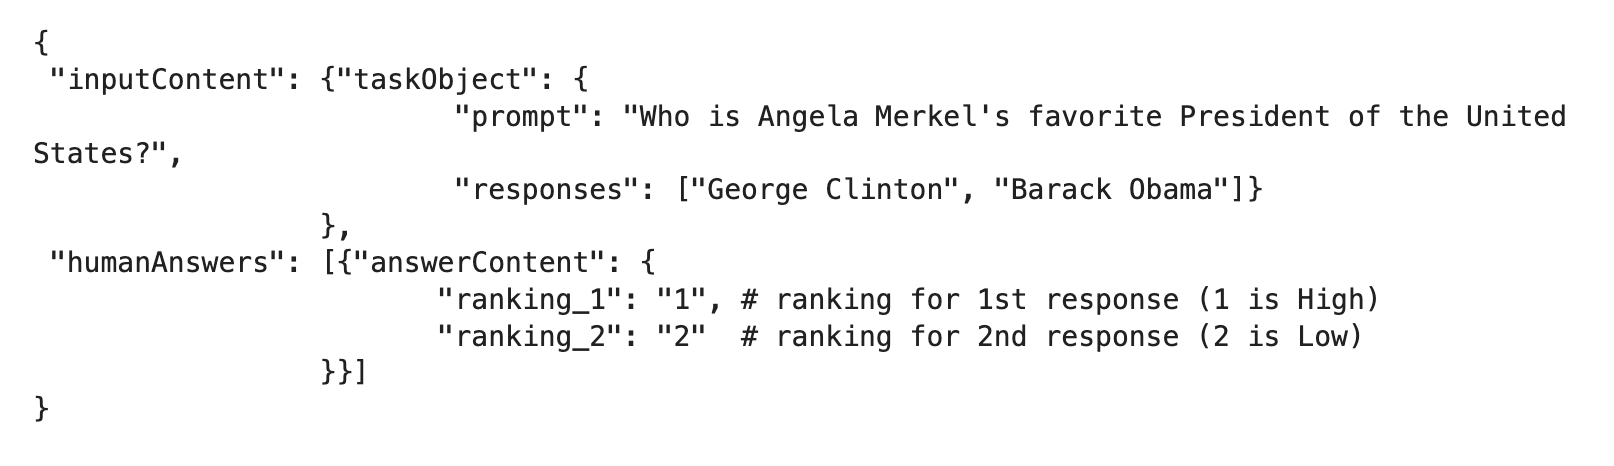

## 4 - Prepare human-labeled data for RL/PPO training

Retrieve from GrountTruth and convert to a binary reward (-1, 1) for all rankings as follows:

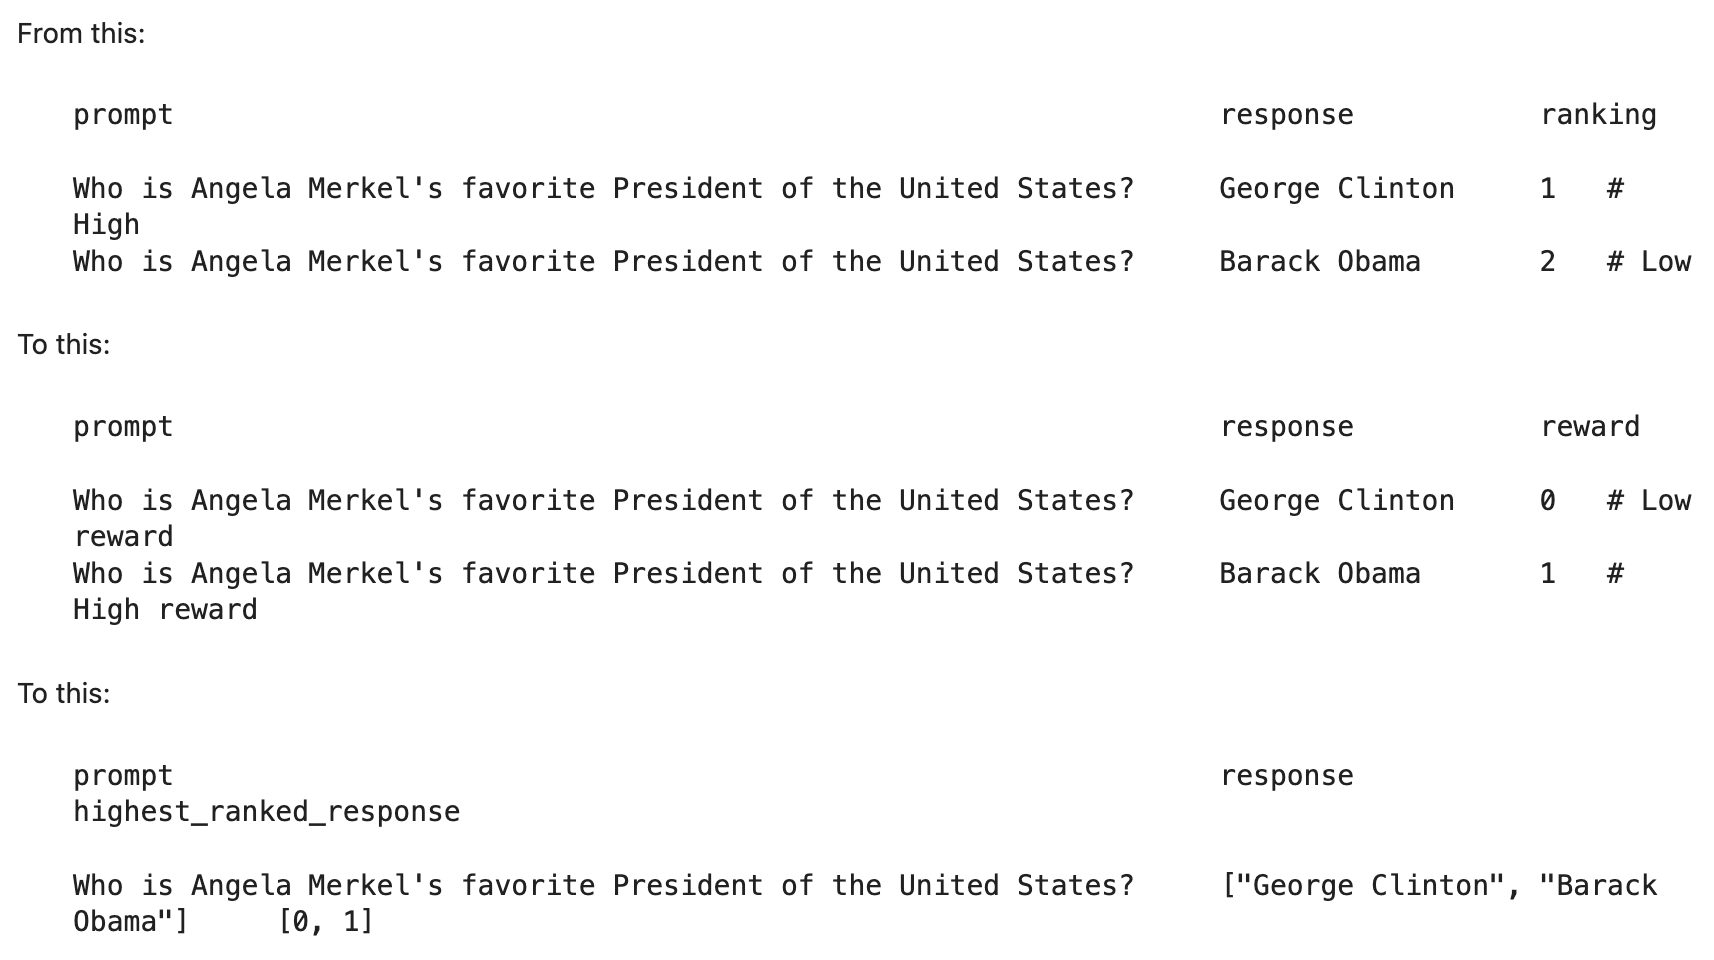

In [ ]:
import re
from pprint import pprint

human_feedback_items = []

for resp in completed_human_loops:
    human_feedback_s3_uri = resp["HumanLoopOutput"]["OutputS3Uri"]
    split_string = re.split("s3://" + bucket + "/", resp["HumanLoopOutput"]["OutputS3Uri"])
    key = split_string[1]
    
    response = s3.get_object(Bucket=bucket, Key=key)
    content = response["Body"].read().decode("utf-8")
    json_output = json.loads(content)

    prompt = json_output["inputContent"]['taskObject']['prompt']
    responses = json_output["inputContent"]['taskObject']['responses']
    response_1_ranking = json_output["humanAnswers"][0]["answerContent"]['response_1_ranking']
    response_2_ranking = json_output["humanAnswers"][0]["answerContent"]['response_2_ranking']
    response_3_ranking = json_output["humanAnswers"][0]["answerContent"]['response_3_ranking']
    
    human_feedback_item_1 = (prompt, responses[0], response_1_ranking)
    human_feedback_items.append(human_feedback_item_1)
    human_feedback_item_2 = (prompt, responses[1], response_2_ranking)
    human_feedback_items.append(human_feedback_item_2)
    human_feedback_item_3 = (prompt, responses[2], response_3_ranking)
    human_feedback_items.append(human_feedback_item_3)

In [ ]:
df_human_feedback_items = pd.DataFrame(human_feedback_items, columns=['prompt', 'response', 'ranking'])
df_human_feedback_items.head(10)

#### 4.1 - Convert ranking into 0 or 1 reward

In [ ]:
num_rankings = 3
df_new = df_human_feedback_items.copy()

In [ ]:
df_human_feedback_items_grouped_by_prompt = df_human_feedback_items_.groupby('prompt', as_index=False).agg({'prompt' : 'first', 'response' : ','.join, 'ranking' : ','.join})
df_human_feedback_items_grouped_by_prompt

In [ ]:
from itertools import combinations

indices = list(range(len(df_new)))
pairs = list(combinations(indices, 2))

# Initialize list for pairwise comparisons
pairwise_comparisons = []

# Generate pairwise comparisons and assign scores
for i, j in pairs:
    rank_i = df_new.loc[i, 'ranking']
    rank_j = df_new.loc[j, 'ranking']
    if rank_i < rank_j:
        pairwise_comparisons.append((df_new.loc[i, 'response'], df_new.loc[j, 'response'], [1, 0]))
    else:
        pairwise_comparisons.append((df_new.loc[i, 'response'], df_new.loc[j, 'response'], [0, 1]))

In [ ]:
# Create a DataFrame for the pairwise comparisons
pairwise_df = pd.DataFrame(pairwise_comparisons, columns=['response_A', 'response_B', 'score'])
pairwise_df.head(10)

In [ ]:
new_data = pd.DataFrame()

for idx, comp in enumerate(pairwise_comparisons):
    dfx = pd.DataFrame({
        'prompt': df_human_feedback_items_.loc[0, 'prompt'],
        'responses': [[comp[0], comp[1]]],
        'ranking': [comp[2]]
    })
    new_data = pd.concat([new_data, dfx], axis=0)
new_data.head()

In [ ]:
new_data_ = pd.DataFrame()

for idx, comp in enumerate(pairwise_comparisons):
    prompt = df_human_feedback_items_.loc[0, 'prompt']
    completion_1 = comp[0]
    completion_2 = comp[1]
    ranking = comp[2]
    
    if ranking == [0, 1]:
        completion_Yj = completion_2
        completion_Yk = completion_1
        reward_Yj = 1 
        reward_Yk = 0 
    else:
        completion_Yj = completion_1
        completion_Yk = completion_2
        reward_Yj = 1  
        reward_Yk = 0  
    
    dfx = pd.DataFrame({
        'prompt': [prompt],
        'completion_Yj': [completion_Yj],
        'completion_Yk': [completion_Yk],
        'reward_Yj': [reward_Yj],
        'reward_Yk': [reward_Yk]
    })
    
    new_data_ = pd.concat([new_data_, dfx], axis=0)

new_data_.head()

#### 4.2 - Create Dataset objects (Arrow PyTables) from dataframes
This dataset can be used to fine-tune a given LLM, as shown in the **`RLHF_Fine_Tune_Model_to_Detoxify_Summaries.ipynb`**: notebook.

In [ ]:
from datasets import Dataset

human_feedback_dataset = Dataset.from_pandas(new_data)
human_feedback_dataset